# Exploring Singapore's food culture near major train stations

## Introduction

**Background**

Singapore's Mass Rapid Transport (MRT) is well connected is one of the main transport mode in the country. In 2019, the average daily ridership is at 3.384 million, which is about half the population of Singapore. 

Like any country, going out for food and drinks is common and is a part of the culture where people spending time catching-up with each other, or just trying out new places. Similarly, businesses are also changing, and new ones are appearing. 

**Problem area**

Singapore is a small country and business competition is high. For both business owners and customers, there are too many options to choose from, or compete against.

For this project, we will try to determine the top 10 food and drinks places located around major MRT interchanges. 

**Target Audience**

Hopefully, this observation can help new business owners understand the landscape just a little more before they startup, as well as to help customers  pick their next outing. 

**Scope**

For the purpose of this project, MRT interchanges are the main train networks that connects 2 or more other networks, and excludes those that connects to Light Rail Transits stations.

## Data

The datasets required for this analysis are:

1. List of MRT interchanges and its latitude and longitude. The source can be found in [data.world](https://data.world/hxchua/train-stations-in-singapore) and has the features required:
    1. stn_name
    2. stn_no
    3. latitude
    4. longitude
    5. color (color of the MRT network link)  
    
2. Data for busiest MRT interchanges. [mytransport.sg](http://mytransport.sg) provides monthly ridership statistics, however the data needs to be understood further before using, as it records the entry and exits of the station gantries instead of the passenger count.
3. Nearby venues from Foursquare. We will be using the `explore` API endpoint to source for venues near each of the MRT interchange

At this point, the following sources are identified:

- data.gov.sg
- mytransport.sg
- data.world
- Wikipedia
- Foursquare

## Methodology

### Import required libraries

In [182]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium
import matplotlib.pyplot as plt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim

# import k-means from clustering stage
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print ("Libraries loaded")

Libraries loaded


### 1. Identifying MRT Interchanges
We'll start by taking a look at the list of MRT stations taken from the data.world source. 

In [2]:
sg_mrt_stations_all = pd.read_csv( "data/dataworld-singapore-mrt-stations.csv" )

In [3]:
sg_mrt_stations_all.head(15)

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS
5,153,BARTLEY MRT STATION,CC12,33168.3039,36108.7003,1.342828,103.879746,YELLOW
6,115,BAYFRONT MRT STATION,DT16,30867.0093,29368.6250,1.281874,103.859073,BLUE
7,115,BAYFRONT MRT STATION,CE1,30867.0093,29368.6250,1.281874,103.859073,OTHERS
8,140,BEAUTY WORLD MRT STATION,DT5,21598.1665,35931.2359,1.341223,103.775810,BLUE
9,37,BEDOK MRT STATION,EW5,38757.9520,34024.7048,1.323980,103.929959,GREEN


## Clean up the columns

In [4]:
# remove columns we don't need
sg_mrt_stations_all.drop( ['OBJECTID', 'X', 'Y' ], axis=1, inplace=True )

# rename some columns
sg_mrt_stations_all.rename( columns={ 'Latitude': 'LATITUDE', 'Longitude':'LONGITUDE' }, inplace=True)

# convert color values to lowercase
sg_mrt_stations_all['COLOR'] = sg_mrt_stations_all['COLOR'].str.lower()

sg_mrt_stations_all.head()

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR
0,ADMIRALTY MRT STATION,NS10,1.440585,103.800998,red
1,ALJUNIED MRT STATION,EW9,1.316433,103.882893,green
2,ANG MO KIO MRT STATION,NS16,1.369933,103.849553,red
3,BAKAU LRT STATION,SE3,1.388093,103.905418,others
4,BANGKIT LRT STATION,BP9,1.380018,103.772667,others


In [5]:
# check the shape
sg_mrt_stations_all.shape

(187, 5)

The data provided is structured in a way that the MRT station names that are interchanges are repeated for each train network it is connected to. We can quickly verify this:

In [6]:
sg_mrt_stations_all_grouped = sg_mrt_stations_all.loc[:].groupby('STN_NAME').count()
sg_mrt_stations_all_grouped.rename( columns = { 'STN_NO' : 'TOTAL_STNS' }, inplace=True)
sg_mrt_stations_all_grouped[ ['TOTAL_STNS'] ].sort_values( ['TOTAL_STNS'], ascending=False ).head(10)

,TOTAL_STNS
STN_NAME,
DHOBY GHAUT MRT STATION,3
BOTANIC GARDENS MRT STATION,2
SERANGOON MRT STATION,2
HARBOURFRONT MRT STATION,2
RAFFLES PLACE MRT STATION,2
CITY HALL MRT STATION,2
PROMENADE MRT STATION,2
CHINATOWN MRT STATION,2
TAMPINES MRT STATION,2


From the list above, we can check if **DHOBY GHAUT MRT STATION** is connected to **3** train network lines:

In [7]:
sg_mrt_stations_all[ sg_mrt_stations_all["STN_NAME"] == "DHOBY GHAUT MRT STATION" ]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR
51,DHOBY GHAUT MRT STATION,NS24,1.298701,103.846112,red
52,DHOBY GHAUT MRT STATION,NE6,1.299705,103.845485,purple
53,DHOBY GHAUT MRT STATION,CC1,1.298843,103.846236,yellow


We can confirm that it is indeed connected to 3 stations; **NS24**, **NE6**, and **CC1**.  

With this, we will now proceed with further cleaning and drop rows that are not interchanges.

In [8]:
# Create a dataframe of the interchange names


mrt_interchange_names = sg_mrt_stations_all_grouped.loc[:].reset_index()

# get the indexes of non-interchange stations
indexes_to_drop = mrt_interchange_names[ mrt_interchange_names['TOTAL_STNS'] == 1 ].index 

# drop them
mrt_interchange_names.drop(indexes_to_drop, inplace = True)
mrt_interchange_names.drop(['LATITUDE', 'LONGITUDE', 'COLOR'], axis=1, inplace=True)
mrt_interchange_names.reset_index(inplace=True, drop=True)

mrt_interchange_names.head()

,STN_NAME,TOTAL_STNS
0,BAYFRONT MRT STATION,2
1,BISHAN MRT STATION,2
2,BOTANIC GARDENS MRT STATION,2
3,BUGIS MRT STATION,2
4,BUONA VISTA MRT STATION,2


In [9]:

# add a column to indicate which station is an interchange
sg_mrt_stations_all['IS_INTERCHANGE'] = sg_mrt_stations_all['STN_NAME'].isin( mrt_interchange_names['STN_NAME'] )

# create a new dataframe that are interchanges
mrt_interchanges = sg_mrt_stations_all.loc[ sg_mrt_stations_all['IS_INTERCHANGE'] == True ].copy()
mrt_interchanges.reset_index(inplace=True, drop=True)
mrt_interchanges.head()

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,BAYFRONT MRT STATION,DT16,1.281874,103.859073,blue,True
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
2,BISHAN MRT STATION,CC15,1.351309,103.849150,yellow,True
3,BISHAN MRT STATION,NS17,1.350839,103.848140,red,True
4,BOTANIC GARDENS MRT STATION,DT9,1.322424,103.816136,blue,True


In [10]:
mrt_interchanges

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,BAYFRONT MRT STATION,DT16,1.281874,103.859073,blue,True
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
2,BISHAN MRT STATION,CC15,1.351309,103.849150,yellow,True
3,BISHAN MRT STATION,NS17,1.350839,103.848140,red,True
4,BOTANIC GARDENS MRT STATION,DT9,1.322424,103.816136,blue,True
5,BOTANIC GARDENS MRT STATION,CC19,1.322110,103.814988,yellow,True
6,BUGIS MRT STATION,DT14,1.299551,103.856862,blue,True
7,BUGIS MRT STATION,EW12,1.300465,103.855701,green,True
8,BUONA VISTA MRT STATION,EW21,1.307183,103.790203,green,True
9,BUONA VISTA MRT STATION,CC22,1.306492,103.790665,yellow,True


The provided data contains a **'COLOR'** column which corresponds to color assigned to the train network line. We note that there are colors assigned as 'Others':

In [11]:
mrt_interchanges[ mrt_interchanges['COLOR'] == 'others' ]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
17,EXPO MRT STATION,CG1,1.334550,103.961513,others,True
28,MARINA BAY MRT STATION,CE2,1.276151,103.855089,others,True
44,WOODLANDS MRT STATION,TE2,1.436067,103.787945,others,True


We will correct these values manually as it is faster that to do so. Color references can be checked here: https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations#MRT_stations

In [12]:
# Update using the indexes from the table above
mrt_interchanges.loc[1, 'COLOR'] = 'yellow'
mrt_interchanges.loc[17, 'COLOR'] = 'green'
mrt_interchanges.loc[28, 'COLOR'] = 'yellow'
mrt_interchanges.loc[44, 'COLOR'] = 'brown'


# let's check the values again
mrt_interchanges.loc[[1, 17, 28, 44]]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,yellow,True
17,EXPO MRT STATION,CG1,1.334550,103.961513,green,True
28,MARINA BAY MRT STATION,CE2,1.276151,103.855089,yellow,True
44,WOODLANDS MRT STATION,TE2,1.436067,103.787945,brown,True


Now we will plot these on a map to visulize their positions.

In [18]:
address = 'Singapore, SG'

# geolocator = Nominatim(user_agent="sg_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude

latitude = '1.3503484'
longitude = '103.7809999'
print('The geograpical coordinate of Singapore is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore is 1.3503484, 103.7809999.


In [21]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')


# add markers to map
for lat, lng, label, color in zip(mrt_interchanges['LATITUDE'], mrt_interchanges['LONGITUDE'], mrt_interchanges['STN_NAME'] + "(" + mrt_interchanges['STN_NO'] + ")", mrt_interchanges['COLOR'] ):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
    
map

We have now plotted the stations on each interchange, however, we are more concerned with the general area of these interchanges. Let's clean up the data little further but grouping the data by interchange name and using the `mean` for its latitude and longitude

In [22]:
    
mean_coords = mrt_interchanges.copy()
mean_coords.drop(['STN_NO', 'COLOR'], axis=1, inplace=True )
mean_coords = mean_coords.groupby('STN_NAME').mean()
mean_coords.reset_index(inplace=True)
# print(mean_coords.shape)
# print( mean_coords[ mean_coords['STN_NAME'] == 'BISHAN MRT STATION'] )

current_station = ''

mrt_interchanges_mean = pd.DataFrame(columns=['STN_NAME', 'MEAN_LATITUDE', 'MEAN_LONGITUDE'] ).copy()

for index, row in mrt_interchanges.iterrows():
    
    if( current_station != row['STN_NAME'] ):
        
        if(current_station != ''):
            mrt_interchanges_mean = mrt_interchanges_mean.append({
                'STN_NAME': current_station, 
                'MEAN_LATITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LATITUDE'].iloc[0],
                'MEAN_LONGITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LONGITUDE'].iloc[0]
            }, ignore_index=True)
        
        current_station = row['STN_NAME']
#         print(current_station)
        

# save the last data    
mrt_interchanges_mean = mrt_interchanges_mean.append({
    'STN_NAME': current_station, 
    'MEAN_LATITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LATITUDE'].iloc[0],
    'MEAN_LONGITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LONGITUDE'].iloc[0]
}, ignore_index=True)

# check that we have the same number of rows
mean_coords.shape[0] == mrt_interchanges_mean.shape[0]

True

Check again how many interchanges we have

In [23]:
mrt_interchanges_mean.shape

(22, 3)

In [24]:
mrt_interchanges_mean.head()

,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,BAYFRONT MRT STATION,1.281874,103.859073
1,BISHAN MRT STATION,1.351074,103.848645
2,BOTANIC GARDENS MRT STATION,1.322267,103.815562
3,BUGIS MRT STATION,1.300008,103.856281
4,BUONA VISTA MRT STATION,1.306838,103.790434


In [25]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')


# add markers to map
for lat, lng, label in zip(mrt_interchanges_mean['MEAN_LATITUDE'], mrt_interchanges_mean['MEAN_LONGITUDE'], mrt_interchanges_mean['STN_NAME'] ):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
    
map

### Now we have plotted a map showing the 22 MRT interchanges in Singapore. Next we will figure out which of these are the most busiest

## 2. Exploring the busiest interchanges  

The data we are using is provided by Singapore's Land Trasport Authority. We will be using the data from October 2020.

### TO ADD

In [26]:
passengers_oct2020 = pd.read_csv('data/transport_node_train_202010.csv')

  
Lets examine the data

In [27]:
passengers_oct2020.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2020-10,WEEKDAY,11,TRAIN,NS7,2353,1912
1,2020-10,WEEKENDS/HOLIDAY,11,TRAIN,NS7,1434,1940
2,2020-10,WEEKDAY,16,TRAIN,SW4,1033,1457
3,2020-10,WEEKENDS/HOLIDAY,16,TRAIN,SW4,514,522
4,2020-10,WEEKDAY,10,TRAIN,CC5,1319,3515


The data shows the hourly (TIME_PER_HOUR) taps in and out of each station, separated by Weekdays and Weekends/Holiday. We will clean up the data now by doing a few things:
- Create a new **AVG_PASSENGERS** column as a mean of the Tap In and Tap Out values
- Drop the **Tap In** and **Tap Out** columns after calculating the mean
- Drop the **AVG_PASSENGERS** column as we know that this data is for TRAIN only. 

In [28]:
# get the mean of passengers moving through the station
passengers_oct2020['AVG_PASSENGERS'] = passengers_oct2020[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'] ] .mean(axis=1)

# remove columns we don't need
# passengers_oct2020.drop( ['PT_TYPE', 'TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], axis=1, inplace=True )
passengers_oct2020.drop( 'PT_TYPE', axis=1, inplace=True )

In [29]:
passengers_oct2020.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
0,2020-10,WEEKDAY,11,NS7,2353,1912,2132.5
1,2020-10,WEEKENDS/HOLIDAY,11,NS7,1434,1940,1687.0
2,2020-10,WEEKDAY,16,SW4,1033,1457,1245.0
3,2020-10,WEEKENDS/HOLIDAY,16,SW4,514,522,518.0
4,2020-10,WEEKDAY,10,CC5,1319,3515,2417.0


Interchanges in this datasets are separates by a '/' on the PT_CODE column:

In [30]:
passengers_oct2020[ passengers_oct2020.PT_CODE.str.contains('/') ].head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
12,2020-10,WEEKDAY,18,EW24/NS1,167094,127122,147108.0
13,2020-10,WEEKENDS/HOLIDAY,18,EW24/NS1,37152,36741,36946.5
22,2020-10,WEEKENDS/HOLIDAY,6,NS24/NE6/CC1,853,1844,1348.5
23,2020-10,WEEKDAY,6,NS24/NE6/CC1,2819,8052,5435.5
26,2020-10,WEEKDAY,10,CC22/EW21,9976,14774,12375.0


Additionally, the data does not contain any station names. We will  address it by doing the following:
1. Splitting the values by '/', and then duplicate row with each PT_CODE value
2. Assign the station names using the data from the previous section
3. Remove the duplicates

#### 1. Splitting the values by '/', and then duplicate row with each PT_CODE value

In [31]:
# passengers_oct2020[ passengers_oct2020['PT_CODE'] == sg_mrt_stations_inx['Station No'] ]
# passengers_oct2020['PT_CODE']


passengers_oct2020_temp = ( passengers_oct2020.set_index( passengers_oct2020.columns.drop('PT_CODE', 1).tolist())
   .PT_CODE.str.split('/', expand=True)
   .stack()
   .reset_index()
   .rename(columns={0:'PT_CODE'})
   .loc[:, passengers_oct2020.columns]
)

passengers_oct2020_temp.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
0,2020-10,WEEKDAY,11,NS7,2353,1912,2132.5
1,2020-10,WEEKENDS/HOLIDAY,11,NS7,1434,1940,1687.0
2,2020-10,WEEKDAY,16,SW4,1033,1457,1245.0
3,2020-10,WEEKENDS/HOLIDAY,16,SW4,514,522,518.0
4,2020-10,WEEKDAY,10,CC5,1319,3515,2417.0


We can use the **AVG_PASSENGERS** value of `1348.5` for `NS24/NE6/CC1` (see `head()` above), to check if they are indeed splitted out into 3 rows

In [32]:
passengers_oct2020_temp[ passengers_oct2020_temp.AVG_PASSENGERS == 1348.5 ] # all ok

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
24,2020-10,WEEKENDS/HOLIDAY,6,NS24,853,1844,1348.5
25,2020-10,WEEKENDS/HOLIDAY,6,NE6,853,1844,1348.5
26,2020-10,WEEKENDS/HOLIDAY,6,CC1,853,1844,1348.5


#### 2. Assign the station names using the data from the previous section

Now we will merge the data with `mrt_interchanges`

In [33]:
# we will merge both data on the MRT station column.

passengers_oct2020_merged = passengers_oct2020_temp.merge(
    mrt_interchanges,
    left_on='PT_CODE',
    right_on='STN_NO'
)

passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,2020-10,WEEKDAY,18,EW24,167094,127122,147108.0,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
1,2020-10,WEEKENDS/HOLIDAY,18,EW24,37152,36741,36946.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
2,2020-10,WEEKDAY,11,EW24,30834,59842,45338.0,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
3,2020-10,WEEKENDS/HOLIDAY,11,EW24,15809,33954,24881.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
4,2020-10,WEEKENDS/HOLIDAY,22,EW24,23101,7594,15347.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True


Let's confirm the merge is correct. We'll compare the name of interchange `NE6`

In [34]:
print( passengers_oct2020_merged[ passengers_oct2020_merged.PT_CODE=='NE6'].iloc[0, 7] )
print( mrt_interchanges[ mrt_interchanges.STN_NO =='NE6' ].iloc[0, 0] )

passengers_oct2020_merged[ passengers_oct2020_merged.PT_CODE=='NE6'].iloc[0, 7] == mrt_interchanges[ mrt_interchanges.STN_NO =='NE6' ].iloc[0, 0]

DHOBY GHAUT MRT STATION
DHOBY GHAUT MRT STATION


True

#### 3. Remove the duplicates

To do this, we will remove unused columns including station codes (e.g, NE6)

In [35]:
passengers_oct2020_merged.drop( ['PT_CODE', 'STN_NO', 'COLOR', 'IS_INTERCHANGE', 'LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

In [36]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME
0,2020-10,WEEKDAY,18,167094,127122,147108.0,JURONG EAST MRT STATION
1,2020-10,WEEKENDS/HOLIDAY,18,37152,36741,36946.5,JURONG EAST MRT STATION
2,2020-10,WEEKDAY,11,30834,59842,45338.0,JURONG EAST MRT STATION
3,2020-10,WEEKENDS/HOLIDAY,11,15809,33954,24881.5,JURONG EAST MRT STATION
4,2020-10,WEEKENDS/HOLIDAY,22,23101,7594,15347.5,JURONG EAST MRT STATION


In [37]:
# Join the mean lat/long columns


passengers_oct2020_merged = passengers_oct2020_merged.merge( 
    mrt_interchanges_mean,
    on='STN_NAME'   
)


In [38]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,2020-10,WEEKDAY,18,167094,127122,147108.0,JURONG EAST MRT STATION,1.333153,103.742311
1,2020-10,WEEKENDS/HOLIDAY,18,37152,36741,36946.5,JURONG EAST MRT STATION,1.333153,103.742311
2,2020-10,WEEKDAY,11,30834,59842,45338.0,JURONG EAST MRT STATION,1.333153,103.742311
3,2020-10,WEEKENDS/HOLIDAY,11,15809,33954,24881.5,JURONG EAST MRT STATION,1.333153,103.742311
4,2020-10,WEEKENDS/HOLIDAY,22,23101,7594,15347.5,JURONG EAST MRT STATION,1.333153,103.742311


In [39]:
passengers_oct2020_merged.shape

(1800, 9)

In [40]:
passengers_oct2020_merged = passengers_oct2020_merged.drop_duplicates()

In [41]:
passengers_oct2020_merged.sort_values('TIME_PER_HOUR', ascending=True, inplace=True)
passengers_oct2020_merged.reset_index(inplace=True, drop=True)

In [42]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,2020-10,WEEKENDS/HOLIDAY,0,191,401,296.0,PAYA LEBAR MRT STATION,1.317771,103.892604
1,2020-10,WEEKENDS/HOLIDAY,0,48,323,185.5,MACPHERSON MRT STATION,1.326211,103.889804
2,2020-10,WEEKENDS/HOLIDAY,0,105,77,91.0,DHOBY GHAUT MRT STATION,1.299083,103.845944
3,2020-10,WEEKDAY,0,262,186,224.0,DHOBY GHAUT MRT STATION,1.299083,103.845944
4,2020-10,WEEKDAY,0,86,299,192.5,CHINATOWN MRT STATION,1.284554,103.843936


### Prepare data for plotting

Now let's figure which station has the highest number of passengers. To do this, we will sum the AVG_PASSENGERS for each station

In [189]:
passengers_plot = passengers_oct2020_merged[['STN_NAME', 'DAY_TYPE', 'TIME_PER_HOUR', 'AVG_PASSENGERS']].copy()
passengers_plot = passengers_plot.pivot_table(
    index=['STN_NAME', 'DAY_TYPE'],
    columns='TIME_PER_HOUR',
    values='AVG_PASSENGERS'
)
passengers_plot['TOTAL_PASSENGERS'] = passengers_plot.sum(axis=1)

passengers_plot.rename_axis(None, axis=1)
passengers_plot.reset_index(inplace=True)

passengers_plot = passengers_plot[['STN_NAME', 'DAY_TYPE', 'TOTAL_PASSENGERS']]
passengers_plot = passengers_plot.pivot_table(
    index=['STN_NAME'],
    columns='DAY_TYPE',
    values='TOTAL_PASSENGERS'
)
passengers_plot.reset_index(inplace=True)
passengers_plot.rename(columns= {'WEEKDAY': 'WEEKDAY_TOTAL', 'WEEKENDS/HOLIDAY':'WEEKENDS_TOTAL'}, inplace=True)
passengers_plot['TOTAL_PASSENGERS'] = passengers_plot.sum(axis=1)
passengers_plot.columns.name = None

passengers_plot


,STN_NAME,WEEKDAY_TOTAL,WEEKENDS_TOTAL,TOTAL_PASSENGERS
0,BAYFRONT MRT STATION,266756.0,150838.0,417594.0
1,BISHAN MRT STATION,263544.5,75342.0,338886.5
2,BOTANIC GARDENS MRT STATION,91551.5,47772.0,139323.5
3,BUGIS MRT STATION,605781.0,289091.5,894872.5
4,BUONA VISTA MRT STATION,328225.0,77762.5,405987.5
5,CHINATOWN MRT STATION,639635.0,267550.0,907185.0
6,CITY HALL MRT STATION,457194.0,229487.0,686681.0
7,DHOBY GHAUT MRT STATION,411507.5,193438.5,604946.0
8,EXPO MRT STATION,158178.5,47572.0,205750.5
9,HARBOURFRONT MRT STATION,473998.5,240339.5,714338.0


In [190]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

### Plot the busiest stations

Let's take a look at how all the stations rank by average daily passengers

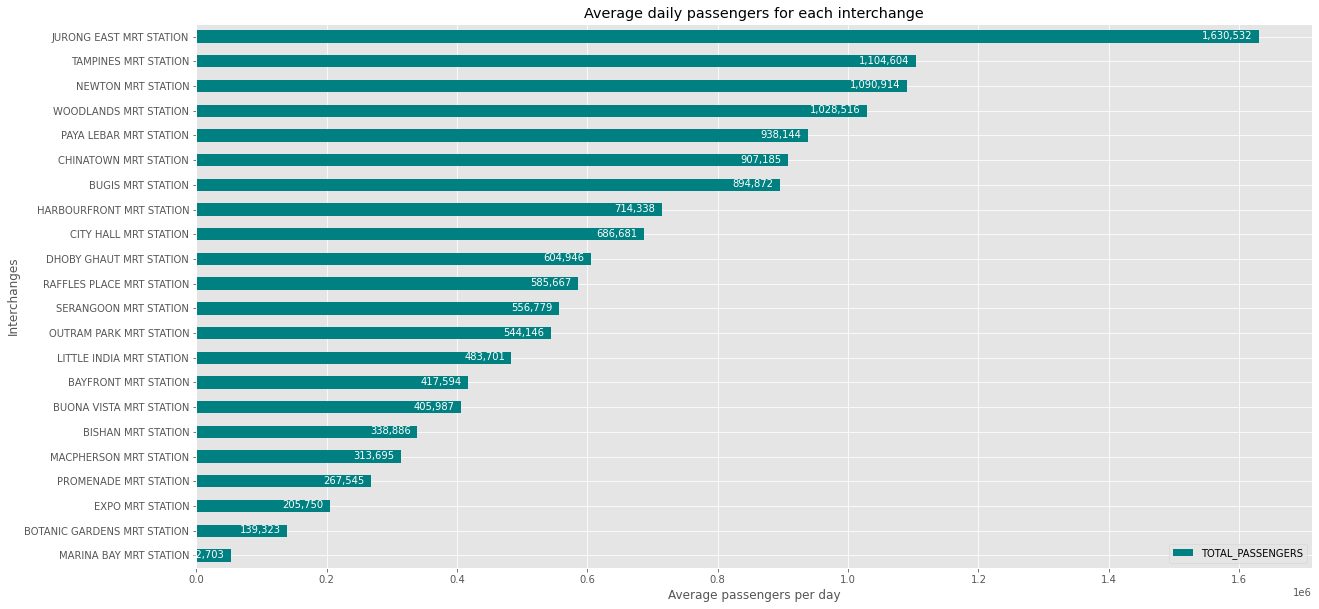

In [191]:
passengers_plot.sort_values('TOTAL_PASSENGERS', ascending=True, inplace=True)

ax = passengers_plot.plot(kind='barh', figsize=(20, 10), x='STN_NAME', y='TOTAL_PASSENGERS', color='teal' , width=0.5 )
ax.legend( loc='lower right' )

for index, value in enumerate(passengers_plot['TOTAL_PASSENGERS']): 
    label = format(int(value), ',') # format int with commas
    
    plt.annotate(label, xy=(value - 10000, index - 0.10), color='white', ha='right' )

plt.title('Average daily passengers for each interchange')
plt.xlabel('Average passengers per day')
plt.ylabel('Interchanges')
plt.show()


#### From the above, the top 5 interchanges are
- Jurong East
- Tampines
- Newton
- Woodlands
- Paya Lebar

Update the map for these 5 locations.

In [192]:
## CODE FOR TOP 5
passengers_plot.sort_values('TOTAL_PASSENGERS', ascending=False, inplace=True)
passengers_plot.reset_index(inplace=True, drop=True)
passengers_plot_top5 = passengers_plot.head(5)

top5_interchanges = mrt_interchanges_mean[ mrt_interchanges_mean['STN_NAME'].isin(passengers_plot_top5['STN_NAME']) ].copy()
top5_interchanges.reset_index(inplace=True, drop=True)
top5_interchanges = top5_interchanges.join( passengers_plot_top5[['TOTAL_PASSENGERS']] )

top5_interchanges


,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE,TOTAL_PASSENGERS
0,JURONG EAST MRT STATION,1.333153,103.742311,1630532.0
1,NEWTON MRT STATION,1.312964,103.837897,1104604.0
2,PAYA LEBAR MRT STATION,1.317771,103.892604,1090914.5
3,TAMPINES MRT STATION,1.354189,103.944074,1028516.0
4,WOODLANDS MRT STATION,1.436471,103.787222,938144.5


In [237]:
## TEMP CODE TO USE ALL

passengers_plot.sort_values('STN_NAME', ascending=True, inplace=True)
passengers_plot.reset_index(inplace=True, drop=True)

mrt_interchanges_mean.sort_values('STN_NAME', ascending=True, inplace=True)
mrt_interchanges_mean.reset_index(inplace=True, drop=True)


# passengers_plot.sort_values('TOTAL_PASSENGERS', ascending=False, inplace=True)
# passengers_plot.reset_index(inplace=True, drop=True)
# passengers_plot_top5 = passengers_plot.copy()

top5_interchanges = passengers_plot[ ['STN_NAME', 'TOTAL_PASSENGERS'] ].copy()
# # top5_interchanges.reset_index(inplace=True, drop=True)
# top5_interchanges = top5_interchanges.join( mrt_interchanges_mean, on='STN_NAME' )

top5_interchanges = top5_interchanges.join( mrt_interchanges_mean[['MEAN_LATITUDE', 'MEAN_LONGITUDE']] )




In [238]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

num=1
# add markers to map
for lat, lng, label in zip(top5_interchanges['MEAN_LATITUDE'], top5_interchanges['MEAN_LONGITUDE'], top5_interchanges['STN_NAME']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map)  
    
    num+=1

    
    
map

## 3. Getting Foursquare venues around each interchange

In [148]:
CLIENT_ID = 'QMAGZJ13AIHHQI4WPVVAIWUTRI1JUQXC0I04S3VONCLPIJ4J' # your Foursquare ID
CLIENT_SECRET = '01KL5EY4PPIWPEWFU3UB1YDAILL2EPVNZKFHYUZJKFIRONNG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QMAGZJ13AIHHQI4WPVVAIWUTRI1JUQXC0I04S3VONCLPIJ4J
CLIENT_SECRET:01KL5EY4PPIWPEWFU3UB1YDAILL2EPVNZKFHYUZJKFIRONNG


In [119]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print(venues_list)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['STN_NAME', 
                  'STN_LATITUDE', 
                  'STN_LONGITUDE', 
                  'VENUE', 
                  'VENUE_LATITUDE', 
                  'VENUE_LONGITUDE', 
                  'VENUE_CATEGORY']
    
    return(nearby_venues)

In [239]:
# type your answer here
names = top5_interchanges.loc[:, 'STN_NAME']
lats = top5_interchanges.loc[:, 'MEAN_LATITUDE']
longs = top5_interchanges.loc[:, 'MEAN_LONGITUDE']

nearby_venues = getNearbyVenues( names, lats, longs)
print('DONE')

BAYFRONT MRT STATION
BISHAN MRT STATION
BOTANIC GARDENS MRT STATION
BUGIS MRT STATION
BUONA VISTA MRT STATION
CHINATOWN MRT STATION
CITY HALL MRT STATION
DHOBY GHAUT MRT STATION
EXPO MRT STATION
HARBOURFRONT MRT STATION
JURONG EAST MRT STATION
LITTLE INDIA MRT STATION
MACPHERSON MRT STATION
MARINA BAY MRT STATION
NEWTON MRT STATION
OUTRAM PARK MRT STATION
PAYA LEBAR MRT STATION
PROMENADE MRT STATION
RAFFLES PLACE MRT STATION
SERANGOON MRT STATION
TAMPINES MRT STATION
WOODLANDS MRT STATION
[[('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Din Tai Fung 鼎泰豐', 1.28227, 103.857608, 'Dumpling Restaurant'), ('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Spago', 1.2836150670349686, 103.86068226520949, 'Italian Restaurant'), ('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Adrift by David Myers', 1.2831409761088732, 103.86045270092075, 'Gastropub'), ('BAYFRONT MRT STATION', 1.281873788, 103.8590733, 'Waku Ghin', 1.2839768321341032, 103.8585974769517, 'Japanese Restaurant'), ('BAYFRO

In [150]:
nearby_venues.head()

,STN_NAME,STN_LATITUDE,STN_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_CATEGORY
0,JURONG EAST MRT STATION,1.333153,103.742311,Johan Paris,1.334083,103.742384,Bakery
1,JURONG EAST MRT STATION,1.333153,103.742311,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese Restaurant
2,JURONG EAST MRT STATION,1.333153,103.742311,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese Restaurant
3,JURONG EAST MRT STATION,1.333153,103.742311,Pepper Lunch,1.333362,103.743086,Japanese Restaurant
4,JURONG EAST MRT STATION,1.333153,103.742311,Dian Xiao Er 店小二 (Dian Xiao Er),1.333447,103.743094,Chinese Restaurant


In [240]:
# 307 venues in total across all
nearby_venues.shape

(1188, 7)

In [241]:
# one hot everything
categories_onehot = pd.get_dummies( nearby_venues[['VENUE_CATEGORY']], prefix="", prefix_sep="")
categories_onehot.shape

(1188, 92)

In [242]:
# add neighborhood column back to dataframe
categories_onehot['STN_NAME'] = nearby_venues['STN_NAME'] 

# # move neighborhood column to the first column
fixed_columns = [categories_onehot.columns[-1]] + list(categories_onehot.columns[:-1])
categories_onehot = categories_onehot[fixed_columns]

categories_onehot.head()


,STN_NAME,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Gastropub,German Restaurant,Greek Restaurant,Hainan Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Macanese Restaurant,Malay Restaurant,Manchu Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Snack Place,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,BAYFRONT MRT STATION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [243]:
categories_onehot.shape

(1188, 93)

In [244]:
# categories_onehot.groupby('STN_NAME').mean().reset_index()

# Get the average of each venue by interchange
categories_onehot_grouped = categories_onehot.groupby('STN_NAME').mean().reset_index()
categories_onehot_grouped


,STN_NAME,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,English Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Fujian Restaurant,Gastropub,German Restaurant,Greek Restaurant,Hainan Restaurant,Halal Restaurant,Hawaiian Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Macanese Restaurant,Malay Restaurant,Manchu Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Satay Restaurant,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Snack Place,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,BAYFRONT MRT STATION,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.078947,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.157895,0.026316,0.105263,0.00000,0.00000,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316,0.026316,0.000000,0.000000,0.000000,0.00000,0.026316,0.000000,0.026316,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.026316,0.026316,0.026316,0.052632,0.000000,0.078947,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.052632,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.026316,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.026316,0.000000,0.00000,0.000000,0.000000,0.000000,0.026316,0.00000,0.000000,0.000000,0.000000,0.000000
1,BISHAN MRT STATION,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130435,0.000000,0.130435,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.00000,0.217391,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.043478,0.000000,0.086957,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.0,0.000000,0.043478,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.00000,0.000000,0.000000,0.043478,0.000000,0.00000,0.000000,0.043478,0.000000,0.000000
2,BOTANIC GARDENS MRT STATION,0.000000,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.100000,0.000000,0.066667,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.00000,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.00,0.00,0.000000,0.100000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.066667,0.00000,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.00000,0.000

In [245]:
categories_onehot_grouped.shape

(22, 93)

In [246]:
num_top_venues = 5

for hood in categories_onehot_grouped['STN_NAME']:
    print("----"+hood+"----")
    temp = categories_onehot_grouped[categories_onehot_grouped['STN_NAME'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BAYFRONT MRT STATION----
                 venue  freq
0                 Café  0.16
1   Chinese Restaurant  0.11
2  Japanese Restaurant  0.08
3               Bistro  0.08
4       Sandwich Place  0.05


----BISHAN MRT STATION----
                 venue  freq
0           Food Court  0.22
1   Chinese Restaurant  0.13
2                 Café  0.13
3     Asian Restaurant  0.09
4  Japanese Restaurant  0.09


----BOTANIC GARDENS MRT STATION----
                venue  freq
0                Café  0.10
1   Indian Restaurant  0.10
2    Malay Restaurant  0.07
3          Steakhouse  0.07
4  Chinese Restaurant  0.07


----BUGIS MRT STATION----
                 venue  freq
0  Japanese Restaurant  0.12
1               Bakery  0.09
2   Chinese Restaurant  0.09
3                 Café  0.08
4           Restaurant  0.05


----BUONA VISTA MRT STATION----
                 venue  freq
0               Bakery  0.10
1  Japanese Restaurant  0.10
2           Food Court  0.07
3     Asian Restaurant  0.07
4   Chi

In [247]:
# row is the row with all the venues
def return_most_common_venues(row, num_top_venues):
    # cut the column, from the 2nd column onwards (skipping the first)
    row_categories = row.iloc[1:]
    # sort the values by highest mean first
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # return the top 10
    return row_categories_sorted.index.values[0:num_top_venues]

In [285]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['STN_NAME']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
# assign all the neighborhoods first
neighborhoods_venues_sorted['STN_NAME'] = categories_onehot_grouped['STN_NAME']

# start a loop based on grouped neighborhood
for ind in np.arange(categories_onehot_grouped.shape[0]):
    # manhattan_grouped.iloc[ind, :] - cuts the row
    # num_top_venues is 10, as per above
    
    # assign the value on this row, replacing 2nd column onwards
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(categories_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,STN_NAME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BAYFRONT MRT STATION,Café,Chinese Restaurant,Bistro,Japanese Restaurant,Sandwich Place,Noodle House,Italian Restaurant,French Restaurant,Gastropub,Food Court
1,BISHAN MRT STATION,Food Court,Chinese Restaurant,Café,Asian Restaurant,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Shaanxi Restaurant,Fried Chicken Joint,Dumpling Restaurant
2,BOTANIC GARDENS MRT STATION,Indian Restaurant,Café,Steakhouse,Asian Restaurant,Chinese Restaurant,Bakery,Malay Restaurant,Noodle House,Spanish Restaurant,Satay Restaurant
3,BUGIS MRT STATION,Japanese Restaurant,Chinese Restaurant,Bakery,Café,Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Indian Restaurant,Sandwich Place
4,BUONA VISTA MRT STATION,Japanese Restaurant,Bakery,Chinese Restaurant,Asian Restaurant,Food Court,Indian Restaurant,Salad Place,Café,Fast Food Restaurant,Bistro


## 4. Cluster 


In [286]:
# set number of clusters
kclusters = 4

categories_grouped_clustering = categories_onehot_grouped.drop('STN_NAME', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(categories_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 1, 1, 3, 1, 1, 1, 1], dtype=int32)

In [287]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

interchanges_merged = top5_interchanges

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
interchanges_merged = interchanges_merged.join(neighborhoods_venues_sorted.set_index('STN_NAME'), on='STN_NAME')

interchanges_merged.head() # check the last columns!

,STN_NAME,TOTAL_PASSENGERS,MEAN_LATITUDE,MEAN_LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BAYFRONT MRT STATION,417594.0,1.281874,103.859073,1,Café,Chinese Restaurant,Bistro,Japanese Restaurant,Sandwich Place,Noodle House,Italian Restaurant,French Restaurant,Gastropub,Food Court
1,BISHAN MRT STATION,338886.5,1.351074,103.848645,0,Food Court,Chinese Restaurant,Café,Asian Restaurant,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Shaanxi Restaurant,Fried Chicken Joint,Dumpling Restaurant
2,BOTANIC GARDENS MRT STATION,139323.5,1.322267,103.815562,1,Indian Restaurant,Café,Steakhouse,Asian Restaurant,Chinese Restaurant,Bakery,Malay Restaurant,Noodle House,Spanish Restaurant,Satay Restaurant
3,BUGIS MRT STATION,894872.5,1.300008,103.856281,1,Japanese Restaurant,Chinese Restaurant,Bakery,Café,Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Indian Restaurant,Sandwich Place
4,BUONA VISTA MRT STATION,405987.5,1.306838,103.790434,1,Japanese Restaurant,Bakery,Chinese Restaurant,Asian Restaurant,Food Court,Indian Restaurant,Salad Place,Café,Fast Food Restaurant,Bistro


In [288]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(interchanges_merged['MEAN_LATITUDE'], interchanges_merged['MEAN_LONGITUDE'], interchanges_merged['STN_NAME'], interchanges_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [295]:
interchanges_merged.loc[interchanges_merged['Cluster Labels'] == 1, interchanges_merged.columns[[0] + list(range(5, interchanges_merged.shape[1]))]]

,STN_NAME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BAYFRONT MRT STATION,Café,Chinese Restaurant,Bistro,Japanese Restaurant,Sandwich Place,Noodle House,Italian Restaurant,French Restaurant,Gastropub,Food Court
2,BOTANIC GARDENS MRT STATION,Indian Restaurant,Café,Steakhouse,Asian Restaurant,Chinese Restaurant,Bakery,Malay Restaurant,Noodle House,Spanish Restaurant,Satay Restaurant
3,BUGIS MRT STATION,Japanese Restaurant,Chinese Restaurant,Bakery,Café,Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Indian Restaurant,Sandwich Place
4,BUONA VISTA MRT STATION,Japanese Restaurant,Bakery,Chinese Restaurant,Asian Restaurant,Food Court,Indian Restaurant,Salad Place,Café,Fast Food Restaurant,Bistro
6,CITY HALL MRT STATION,Café,French Restaurant,Italian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Dumpling Restaurant,Ramen Restaurant,Steakhouse,Restaurant
7,DHOBY GHAUT MRT STATION,Café,Japanese Restaurant,Korean Restaurant,Sandwich Place,Asian Restaurant,Burger Joint,Sushi Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant
8,EXPO MRT STATION,Café,Asian Restaurant,Chinese Restaurant,Fast Food Restaurant,Food Court,Japanese Restaurant,Indian Restaurant,Filipino Restaurant,Bakery,Soup Place
9,HARBOURFRONT MRT STATION,Chinese Restaurant,Japanese Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Café,Noodle House,Thai Restaurant,Food Court,Vietnamese Restaurant
10,JURONG EAST MRT STATION,Chinese Restaurant,Café,Japanese Restaurant,Food Court,Asian Restaurant,Sandwich Place,Korean Restaurant,Bakery,Fast Food Restaurant,American Restaurant
15,OUTRAM PARK MRT STATION,Asian Restaurant,Italian Restaurant,Café,Chinese Restaurant,Japanese Restaurant,Bakery,Burger Joint,Snack Place,Australian Restaurant,Food Court


In [279]:
from sklearn.metrics import silhouette_samples, silhouette_score

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(categories_onehot_grouped.drop('STN_NAME',1))
    sse.append(kmeans.inertia_)

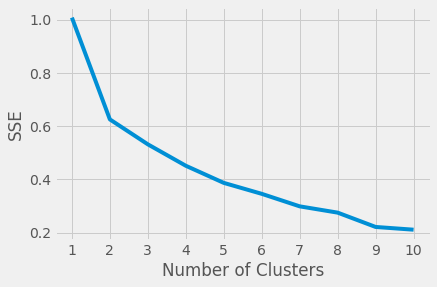

In [280]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [276]:

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(categories_onehot_grouped.drop('STN_NAME',1))
    score = silhouette_score(categories_onehot_grouped.drop('STN_NAME',1), kmeans.labels_)
    silhouette_coefficients.append(score)

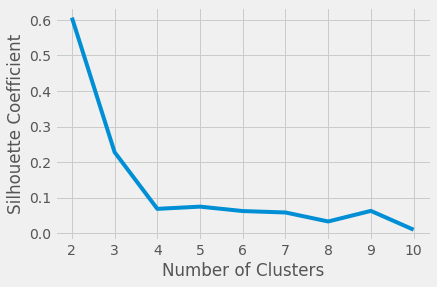

In [277]:

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [61]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

num=1
# add markers to map
for lat, lng, label in zip(nearby_venues['STN_LATITUDE'], nearby_venues['STN_LONGITUDE'], nearby_venues['STN_NAME']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map)  
    
    num+=1

for lat, lng, label in zip(nearby_venues['VENU_LATITUDE'], nearby_venues['VENUE_LONGITUDE'], nearby_venues['VENUE']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup= label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map)  
    
map

## Test submap 1

In [ ]:
data_jurong = nearby_venues[ nearby_venues['STN_NAME'] == 'JURONG EAST MRT STATION']

f = folium.Figure(width=500, height=500)
map = folium.Map(location=[data_jurong.loc[0].STN_LATITUDE, data_jurong.loc[0].STN_LONGITUDE], zoom_start=14, tiles='Stamen Terrain').add_to(f)

num=1


for lat, lng, label in zip(data_jurong['VENU_LATITUDE'], data_jurong['VENUE_LONGITUDE'], data_jurong['VENUE']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=.5,
        parse_html=False).add_to(map)  
    
map


## Results

## Discussion

## Conclusion

In [ ]:
# import pandas library 
import pandas as pd 
  
# dictionary with list object in values 
details = { 
    'Name' : ['Ankit', 'Aishwarya', 'Shaurya', 
              'Shivangi', 'Priya', 'Swapnil'], 
    'Age' : [23, 21, 22, 21, 24, 25], 
    'University' : ['BHU', 'JNU', 'DU', 'BHU',  
                    'Geu', 'Geu'], 
} 
  
# creating a Dataframe object  
df = pd.DataFrame(details, columns = ['Name', 'Age', 
                                      'University'], 
                  index = ['a', 'b', 'c', 'd', 'e', 'f']) 
  
# get names of indexes for which 
# column Age has value 21 
index_names = df[ df['Age'] == 21 ].index 
  
# # drop these row indexes 
# # from dataFrame 
# df.drop(index_names, inplace = True) 
  
# df 
index_names